<a href="https://colab.research.google.com/github/nishantgaurav23/Image-Similarity-Using-Siamese/blob/main/Image_Similarity_Using_Siamese_With_Contrastive_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
**Siamese Networks** are neural networks which share weights between two or more sister networks, each producing embedding vectors of its respective inputs.

In supervised similarity learning, the network are then trained to maximize the contrast(distance) between embeddings of inputs of different classes, while minimizing the distance between embeddings of similar classes, resulting in embedding spaces that reflect the class segmentation of the training inputs.

### Setup

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Hyperparameters

In [2]:
epochs = 10
batch_size = 16
margin = 1 #Margin for contastive loss

### Load the MNIST dataset

In [4]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

#Change the data type to a floating point format
x_train_val =  x_train_val.astype('float32')
x_test = x_test.astype('float32')

### Define training and validation sets

In [5]:
#Keep 50% for train_val in validation set
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]

del x_train_val, y_train_val

### Create a pair of images
We will train the model to differentiate between digits of different classes. For example, digit 0 needs to be differentiated from the rest of the digits (1 through 9), digit 1 - from 0 and 2 through 9 and so on.
For this we select N random images from class A and pair them with N random images from another class B. Then we repeat the process for all classses of digits(until digit 9). Once we have paired digit 0 with other digits, we can repeat the process for the remaining classes for rest of the digit (from 1 until 9)

In [6]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [7]:
print(pairs_train.shape)

(60000, 2, 28, 28)


**pairs_train_shape=(60000, 2, 28, 28)**
* We have 60000 pairs
* Each pair contains 2 images
* Each image has shape (28, 28)

Split the training pairs

In [8]:
x_train_1 = pairs_train[:, 0] # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

Split the validation pairs

In [9]:
x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]

Split the test pairs

In [10]:
x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

### Visualize pairs and their labels

In [11]:
def visulize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
  """ Creates a plot of pairs and labels, prediction if its test dataset.
  Arguments:
      pairs: Numpy array, of pairs to visualize, having shape
             (Number of pairs, 2, 28, 28).
      to_show: Int, number of examples to visualize (default is 6)
               'to_show` must be an integral multiple of `num_col`.
               Otherwise it will be trimmed if it is greater than num_col,
               and incrementd if it is less than num_col

      num_col: Int, number of images in one row - (default is 3)
               For test and train respectively, it should not exceed 3 and 7.

      predictions: Numpy array of predictions with shape (to_show, 1) - (default is None)
                  Must be passes with test=True

      test: Boolean telling whether the dataset being visulzed is train dataset - default False

  Returns:
       None

  """

  # Define num_row
  # If to_show % num_col != 0
  #   trim to_show,
  #     to trin to_show limit num_col to the point where
  #     to show % num_col == 0
  #
  # If to_show//num_col == 0
  #   then it means num_col is greater then to_show
  #   increment to_show
  #     to increment to_show set num_row to 1

  num_row = to_show // num_col if to_show // num_col != 0 else 1
  # to show must be an integral multiple of `num_col`
  # we found num_row and we have num_col
  # to increment or decrement to_show
  # to make it integral multiple of `num_col`
  # simply set it equal to num_row * num_col
  to_show = num_row * num_col

  # Plot the images
  fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
  for i in range(to_show):
    #  If the number of rows is 1, the axes array is one -dimensional
    if num_row == 1:
      ax = axes[i%num_col]
    else:
      ax = axes[i // num_col, i%num_col]

    ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
    ax.set_axis_off()
    if test:
      ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
    else:
      ax.set_title("Label: {}".format(labels[i]))

  if test:
    plt.tight_layout(rect=(0,0, 1.9, 1.9), w_pad=0.0)
  else:
    plt.tight_layout(rect=(0,0, 1.5, 1.5))

  plt.show()
    

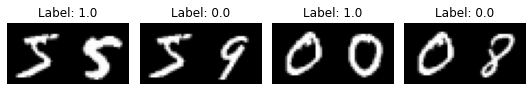

In [12]:
visulize(pairs_train[:-1],labels_train[:-1], to_show=4, num_col=4)

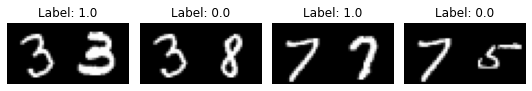

In [13]:
visulize(pairs_val[:-1],labels_val[:-1], to_show=4, num_col=4)

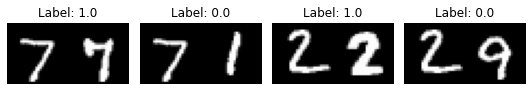

In [14]:
visulize(pairs_test[:-1],labels_test[:-1], to_show=4, num_col=4)

### Define the model
There are two input layers, each leading to its own network, which produces embeddings. A Lambda layer them merges them using euclidean distance and the merged output is fed to the final network.

In [15]:
# Provide two tensors t1 and t2
# Euclidean distance = sqrt(sum(squares(t1-t2)))

def euclidean_distance(vects):
  """Find the Eucidean distance between two vectors.

  Arguments:
    vects: List contaning two tensors of same length

  Returns:
    Tensor containing euclidean distance
    (as floating point value) between vectors
  """

  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input = layers.Input((28,28,1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5,5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28,28,1))
input_2 = layers.Input((28,28,1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use 
# same embedding network for both tower networks.

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model([input_1, input_2], outputs=output_layer)

### Define the contastive loss

In [16]:
def loss(margin=1):
  """Provides 'contrastive_loss' an encoding scope with variable 'margin'.
  Arguments:
    margin: Integer, defines the baseline for distance for which pairs
            should be classfied as dissimilar. - (default is 1)

  Returns:
    'contrastive loss' function with data ('margin') attached
  """
  # Contrastive loss = mean( (1-true_value) * square(prediction) +
  #                         true_value * square( max(margin-prediction, 0)))
  def constrastive_loss(y_true, y_pred):
    """Calculate the constrastive loss.
    Arguments:
      y_true: List of labels, each labels is of type float32.
      y_pred: List of predictions of same length as of y_true,
              each label is of type float 32

    Returns: 
      A tensors contaning constrastive loss as floating point value
    """
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1-y_true) * square_pred + (y_true) * margin_square
    )

  return constrastive_loss

### Compile the model with the contrastive loss

In [17]:
siamese.compile(loss=loss(margin=margin),
                optimizer="RMSprop",
                metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           5318        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

### Train the model

In [18]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/10
3750/3750 [==============================] - 38s 7ms/step - loss: 0.1109 - accuracy: 0.8543 - val_loss: 0.0384 - val_accuracy: 0.9509
Epoch 2/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0541 - accuracy: 0.9284 - val_loss: 0.0268 - val_accuracy: 0.9657
Epoch 3/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0446 - accuracy: 0.9421 - val_loss: 0.0213 - val_accuracy: 0.9731
Epoch 4/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0393 - accuracy: 0.9489 - val_loss: 0.0195 - val_accuracy: 0.9747
Epoch 5/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0359 - accuracy: 0.9539 - val_loss: 0.0175 - val_accuracy: 0.9773
Epoch 6/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0337 - accuracy: 0.9563 - val_loss: 0.0170 - val_accuracy: 0.9781
Epoch 7/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0330 - accuracy: 0.9575 - val_loss: 0.0163 - val_ac

### Visulize the results

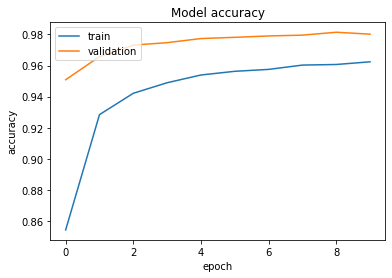

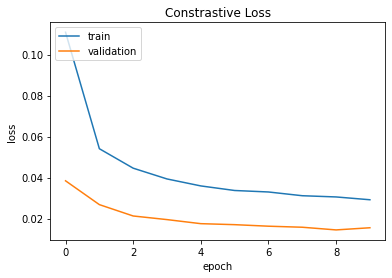

In [20]:
def plt_metric(history, metric, title, has_valid=True):
  """Plot the given 'metric' from history

  Arguments:
    history: history attribute if History object returned from Model fit.
    metrics: Metrics to plot, a string value present as key in history
    title: A string to be used as title of plot
    has_valid: Boolean, true if valid data was passed to model.fit else false.

  Returns:
    None.
  """
  plt.plot(history[metric])
  if has_valid:
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")

  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel("epoch")
  plt.show()

# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")


###Evaluate the model

In [21]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

625/625 [==============================] - 2s 3ms/step - loss: 0.0116 - accuracy: 0.9850
test loss, test acc: [0.011630297638475895, 0.9849500060081482]


# Visualize the predictions

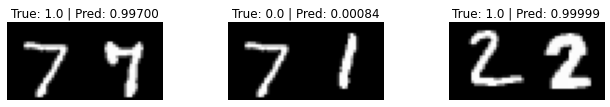

In [27]:
predictions = siamese.predict([x_test_1, x_test_2])
visulize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)